
# Tests using benchmark datasets

Here we provide a walkthrough of running the experimental evaluation using real-world datasets, and visualizing the results.

The contents of this notebook are as follows:

- <a href="#guide">Guide to running the experiments</a>
- <a href="#visual">Processing and visualizing results</a>

First we give some details describing how to actually run the tests on your machine. The remainder of the demo aids the user in visualizing the test results after the experiments have actually been run.


<a id="guide"></a>
## Guide to running the experiments

A high-level description of the full procedure involved in running these experiments is given in the README file of this repository. We assume the user has already covered sections "<a href="https://github.com/feedbackward/mrisk#setup_init">Setup: initial software preparation</a>" and "<a href="https://github.com/feedbackward/mrisk#setup_data">Setup: preparing the benchmark data sets</a>" from the main README file. As such, all that remains to be done here is to fill in the details related to experiment parameter settings.

### Basic flow

Essentially, the experiments are run by calling `learn_driver.py` with the appropriate options (experimental parameters). Results are stored automatically with path and filename as follows:

```
[results_dir]/[data]/[task]-[model]_[algo]-[trial].[descriptor]
```

Here `results_dir` is the directory for storing results, specified in `setup_results.py`. The `descriptor` depends on the method of evaluation used, all specified in `setup_eval.py`. The rest is fairly self-explanatory, though we note that for our experiments, `task` is used to assign a different name corresponding to different settings of the key $\sigma$ parameter.


### Glossary of experimental parameters

- `--algo-ancillary`: specifies the underlying learning algorithm to use (e.g., SGD); call these the *ancillary iterates*.
- `--algo-main`: lets us specify an additional procedure to operate on the ancillary iterates (e.g., do nothing or average SGD iterates, etc.); call these the *main iterates*.
- `--batch-size`: size of mini-batch to use.
- `--data`: the name of the data set to be used.
- `--entropy`: used to ensure consistency across methods.
- `--loss`: the name of the loss function to be used.
- `--model`: the name of the model to be used.
- `--no-mrisk`: if this flag is used, then it tells the learning algorithm to treat the losses as-is, rather than use our "mrisk" loss wrappers.
- `--num-epochs`: the number of passes to make over the training data.
- `--num-procs` (*only in* `learn_rb_run.sh`): control the number of independent sub-processes to be run.
- `--num-trials`: the number of randomized trials to be run.
- `--sigma`: this is the parameter $\sigma$ from the main paper; if set larger than $10^4$, this is parsed as $\sigma = \infty$. If set smaller than $10^{-4}$, this is parsed as $\sigma = 0$.
- `--step-size`: global step-size coefficient (multiplies the step-size computed internally by algorithms).
- `--task-name`: mostly for clerical purposes, when we want to distinguish results for different setups (typically different $\sigma$ settings).


### Detailed parameter settings

The experiments given in our paper (2021/04 arXiv version) are computed using the following experimental parameter settings:

- `--algo-ancillary`: `"SGD"`.
- `--algo-main`: `"Ave"`.
- `--batch-size`: `"8"`
- `--data`: (see dataset names listed in the paper).
- `--loss`: `"logistic"`.
- `--model`: `"linreg_multi"`.
- `--num-epochs`: `"30"`.
- `--num-trials`: `"10"`.
- `--sigma`: `"0.0"`, `"0.1"`, `"1.0"`, `"10.0"`, `"1000000.0"` (corresponds to `--task-name` settings below).
- `--step-size`: `"0.01"`.
- `--task-name`: `"off"` (uses `--no-mrisk` flag), `"zero"`, `"low"`, `"med"`, `"high"`, `"inf"` (corresponds to the `--sigma` settings above).


### Execution

If the shell script `learn_run.sh` has been appropriately modified to reflect any of the above settings, then running the experiments is a one-line operation:

```
(mrisk) $ bash learn_run.sh
```

If you would rather not do these all manually, feel free to use our `remote_*.sh` scripts for convenience.

Once the tests have been run, a collection of raw experimental results should be written to disk. The following section covers the tasks of processing and visualizing these results.

<a id="visual"></a>
## Processing and visualizing results

In [1]:
## External modules.
from contextlib import ExitStack
from itertools import product
import json
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np
import os
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.utils import makedir_safe
from setup_data import dataset_paras
from setup_losses import dev_ext
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Parameters to be set by the user.
data = "emnist_balanced" # specify dataset name
model = "linreg_multi" # specify model name
eval_type = "logistic" # specify evaluation metric (quadratic, absolute, logistic, zero_one)

In [3]:
## Helper functions for customized evaluation.

def risk_theta(theta, losses, sigma):
    '''
    The function to be minimized with respect to theta.
    '''
    return np.mean(theta+dev_ext(u=(losses-theta),
                                 sigma=sigma,
                                 interpolator=False))


def eval_custom(losses, sigma=None, verbose=False):
    '''
    Returns the empirical mrisk parameter estimate.
    '''
    
    if sigma is None:
        mrisks = losses
    else:
        min_result = minimize_scalar(fun=risk_theta, args=(losses,sigma))
        theta_min = min_result.x
        if verbose:
            print("min_result:")
            print(min_result)
        mrisks = theta_min+dev_ext(u=(losses-theta_min),
                                   sigma=sigma,
                                   interpolator=False)
    
    return np.mean(mrisks)
        

In [4]:
## Automated clerical setup.
eval_train = eval_type+"_train"
eval_test = eval_type+"_test"

## Directory setup.
toread_dir = os.path.join(results_dir, data)
makedir_safe(img_dir)

In [5]:
## Specify which methods and sigma-levels (set by task name) to look at.
toplot_name = "SGD_Ave"
toplot_tasks = ["off", "zero", "low", "med", "high", "inf"]

## Colour setup.
task_cmap = cm.get_cmap("plasma")
task_colours = task_cmap(np.linspace(0.0, 1.0, len(toplot_tasks)))

In [6]:
# Gathering of results.
dict_train = {a: [] for a in toplot_tasks}
dict_test = {a: [] for a in toplot_tasks}

sigma_dict = {}

for task_name in toplot_tasks:
    
    fname_base = task_name+"-"+model+"_"+toplot_name
    
    with open(os.path.join(toread_dir, ".".join([fname_base, "json"])), "r", encoding="utf-8") as f:
        json_dict = json.load(f)
        if json_dict["no_mrisk"]:
            sigma_dict[task_name] = None
        else:
            sigma_dict[task_name] = json_dict["sigma"]
    
    trial = 0
    do_gathering = True
    
    while do_gathering:
        
        toread_train = os.path.join(
            toread_dir, ".".join([fname_base+"-"+str(trial), eval_train])
        )
        toread_test = os.path.join(
            toread_dir, ".".join([fname_base+"-"+str(trial), eval_test])
        )
        
        with ExitStack() as stack:
            
            try:
                f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_train, dtype=np.float,
                                   delimiter=",", ndmin=2)
                dict_train[task_name] += [yvals]
            except FileNotFoundError:
                do_gathering = False
                print("({}) Finished collecting training results.".format(task_name))
                
            try:
                f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_test, dtype=np.float,
                                   delimiter=",", ndmin=2)
                dict_test[task_name] += [yvals]
            except FileNotFoundError:
                print("({}) Finished collecting test results.".format(task_name))
        
        ## If the current trial went through, increment to try the next one.
        if do_gathering:
            trial += 1
            
## Process training-set values (one value per (trial,epoch) pair).
dict_train = {a:np.hstack(dict_train[a]).T for a in dict_train.keys()}

## Process test-set values (a full dataset value per (trial,epoch) pair).
for key in dict_test:
    to_stack = []
    for a in dict_test[key]:
        to_stack += [np.expand_dims(a=a, axis=0)]
    dict_test[key] = np.vstack(to_stack)

(off) Finished collecting training results.
(off) Finished collecting test results.
(zero) Finished collecting training results.
(zero) Finished collecting test results.
(low) Finished collecting training results.
(low) Finished collecting test results.
(med) Finished collecting training results.
(med) Finished collecting test results.
(high) Finished collecting training results.
(high) Finished collecting test results.
(inf) Finished collecting training results.
(inf) Finished collecting test results.


In [7]:
## Just for reference, print out the shapes of the data read in.
print("Checking shapes:")
for key in dict_train:
    print(key, type(dict_train[key]), dict_train[key].shape)
for key in dict_test:
    print(key, type(dict_test[key]), dict_test[key].shape)
print("\n")

## Also for reference, print out the sigma dictionary.
print("Sigma dictionary:")
print(sigma_dict)

Checking shapes:
off <class 'numpy.ndarray'> (10, 30)
zero <class 'numpy.ndarray'> (10, 30)
low <class 'numpy.ndarray'> (10, 30)
med <class 'numpy.ndarray'> (10, 30)
high <class 'numpy.ndarray'> (10, 30)
inf <class 'numpy.ndarray'> (10, 30)
off <class 'numpy.ndarray'> (10, 30, 15792)
zero <class 'numpy.ndarray'> (10, 30, 15792)
low <class 'numpy.ndarray'> (10, 30, 15792)
med <class 'numpy.ndarray'> (10, 30, 15792)
high <class 'numpy.ndarray'> (10, 30, 15792)
inf <class 'numpy.ndarray'> (10, 30, 15792)


Sigma dictionary:
{'off': None, 'zero': 0.0, 'low': 0.1, 'med': 1.0, 'high': 10.0, 'inf': 1000000000.0}


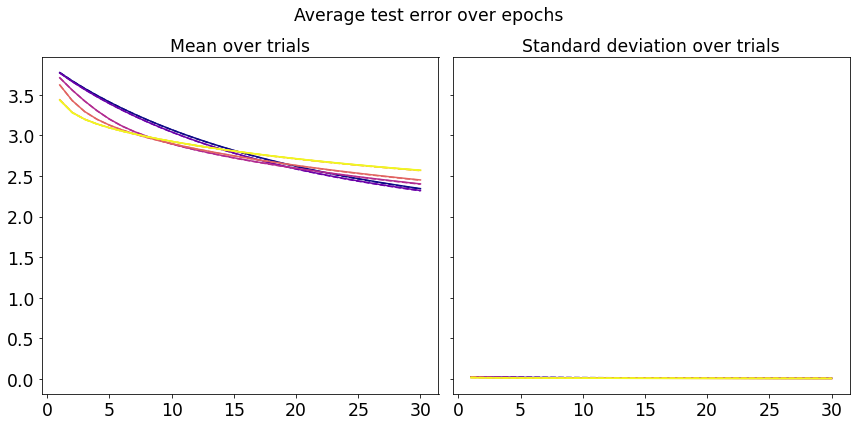

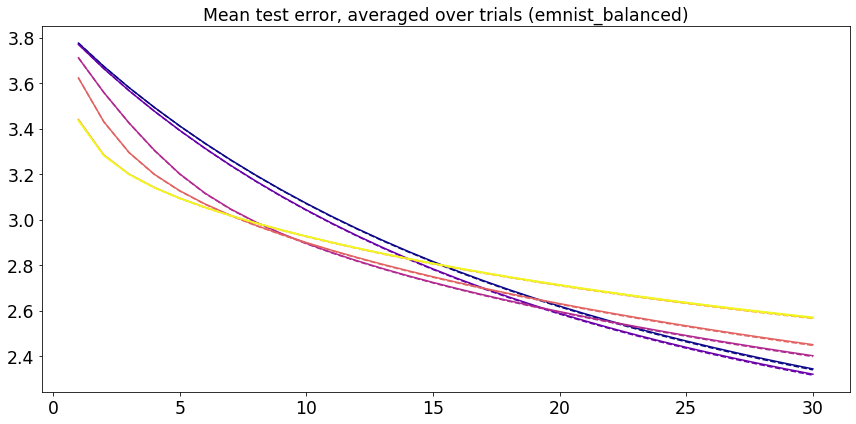

In [8]:
## Sanity check of performance over epochs.

ylim_bottom = 2.45-0.1
ylim_top = 2.45+0.1
ylim_gap = 0.025

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

for task, colour in zip(toplot_tasks, task_colours):
    num_trials, num_epochs = dict_train[task].shape
    x_values = np.arange(0,num_epochs)+1
    y_train = np.mean(dict_train[task], axis=0)
    y_test = np.mean(np.mean(dict_test[task], axis=2), axis=0) # two-axis aggregation.
    ax1.plot(x_values, y_train,
             color=colour,
             label="{} train".format(task),
             ls="--")
    ax1.plot(x_values, y_test,
             color=colour,
             label="{} test".format(task),
             ls="-")
ax1.tick_params(labelsize=my_fontsize)
#ax1.axhline(y=ylim_bottom+ylim_gap, ls="-", color="xkcd:silver")
#ax1.axhline(y=ylim_top-ylim_gap, ls="-", color="xkcd:silver")
ax1.set_title("Mean over trials", size=my_fontsize)
#ax1.legend(loc=0, ncol=2, fontsize=my_fontsize)

for task, colour in zip(toplot_tasks, task_colours):
    num_trials, num_epochs = dict_train[task].shape
    x_values = np.arange(0,num_epochs)+1
    y_train = np.std(dict_train[task], axis=0)
    y_test = np.std(np.mean(dict_test[task], axis=2), axis=0) # two-axis aggregation.
    ax2.plot(x_values, y_train,
             color=colour,
             label="{} train".format(task),
             ls="--")
    ax2.plot(x_values, y_test,
             color=colour,
             label="{} test".format(task),
             ls="-")
ax2.tick_params(labelsize=my_fontsize)
ax2.set_title("Standard deviation over trials", size=my_fontsize)
#ax2.legend(loc=0, ncol=2, fontsize=my_fontsize)

fig.suptitle("Average test error over epochs", size=my_fontsize)
plt.tight_layout()
plt.show()


## Exact same plots, except zoomed in.

fig, ax = plt.subplots(1, 1, figsize=(12,6))

for task, colour in zip(toplot_tasks, task_colours):
    num_trials, num_epochs = dict_train[task].shape
    x_values = np.arange(0,num_epochs)+1
    y_train = np.mean(dict_train[task], axis=0)
    y_test = np.mean(np.mean(dict_test[task], axis=2), axis=0) # two-axis aggregation.
    ax.plot(x_values, y_train,
            color=colour,
            label="{} train".format(task),
            ls="--")
    ax.plot(x_values, y_test,
            color=colour,
            label="{} test".format(task),
            ls="-")
ax.tick_params(labelsize=my_fontsize)
#ax.set_ylim((ylim_bottom,ylim_top))
#ax.axhline(y=ylim_bottom+ylim_gap, ls="-", color="xkcd:silver")
#ax.axhline(y=ylim_top-ylim_gap, ls="-", color="xkcd:silver")
ax.set_title("Mean test error, averaged over trials ({})".format(data), size=my_fontsize)
plt.tight_layout()
fname = os.path.join(img_dir,
                     "ave_{}_{}_{}_{}.{}".format(data, model, toplot_name, eval_type, my_ext))
plt.savefig(fname=fname)
plt.show()


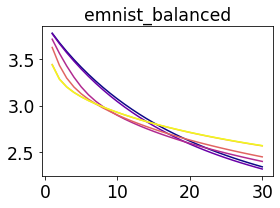

In [9]:
## Once again the same deal, except smaller, for placement within our paper.

fig, ax = plt.subplots(1, 1, figsize=(4,3))

for task, colour in zip(toplot_tasks, task_colours):
    num_trials, num_epochs = dict_train[task].shape
    x_values = np.arange(0,num_epochs)+1
    y_train = np.mean(dict_train[task], axis=0)
    y_test = np.mean(np.mean(dict_test[task], axis=2), axis=0) # two-axis aggregation.
    #ax.plot(x_values, y_train,
    #        color=colour,
    #        label="{} train".format(task),
    #        ls="--")
    ax.plot(x_values, y_test,
            color=colour,
            label="{} test".format(task),
            ls="-")
ax.tick_params(labelsize=my_fontsize)
#ax.set_ylim((ylim_bottom,ylim_top))
#ax.axhline(y=ylim_bottom+ylim_gap, ls="-", color="xkcd:silver")
#ax.axhline(y=ylim_top-ylim_gap, ls="-", color="xkcd:silver")
ax.set_title("{}".format(data), size=my_fontsize)
plt.tight_layout()
fname = os.path.join(img_dir,
                     "avesmall_{}_{}_{}_{}.{}".format(data, model, toplot_name, eval_type, my_ext))
plt.savefig(fname=fname)
plt.show()

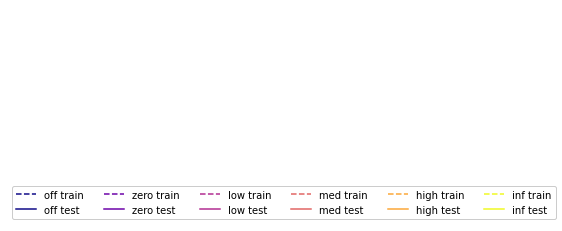

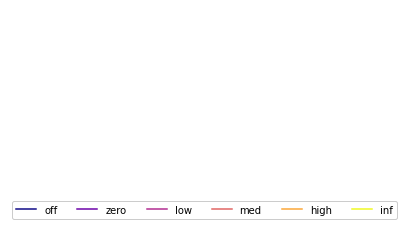

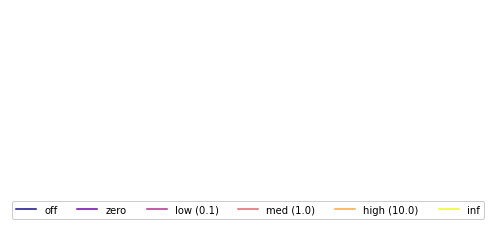

In [10]:
## Print out clean legends for reference.

labels = []
colours = []
linestyles = []
for i, task in enumerate(toplot_tasks):
    labels += [ task+" train", task+" test" ]
    colours += [ task_colours[i] ] * 2
    linestyles += [ "--", "-" ]

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=6, framealpha=1, frameon=True)
fname = os.path.join(img_dir, "legend_plot_trte.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()


labels = []
colours = []
linestyles = []
for i, task in enumerate(toplot_tasks):
    labels += [ task ]
    colours += [ task_colours[i] ]
    linestyles += [ "-" ]

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=6, framealpha=1, frameon=True)
fname = os.path.join(img_dir, "legend_plot_test.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()


toplot_tasks_values = ['off', 'zero', 'low (0.1)', 'med (1.0)', 'high (10.0)', 'inf']
labels = []
colours = []
linestyles = []
for i, task in enumerate(toplot_tasks_values):
    labels += [ task ]
    colours += [ task_colours[i] ]
    linestyles += [ "-" ]

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=6, framealpha=1, frameon=True)
fname = os.path.join(img_dir, "legend_plot_test_values.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()


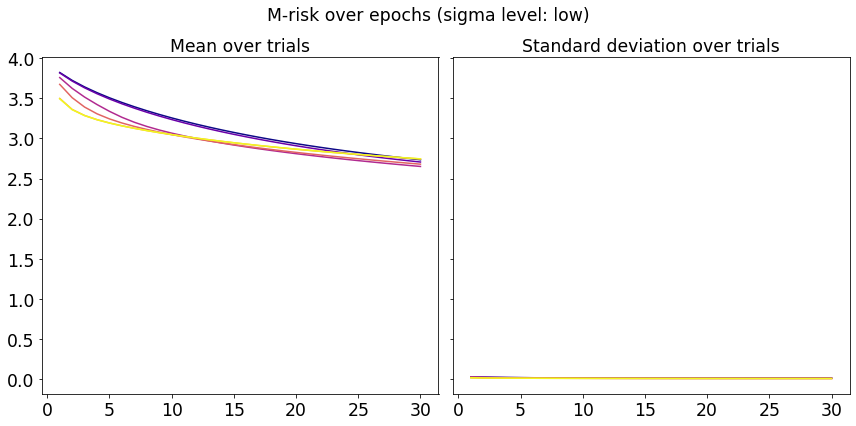

In [11]:
## Performance over epochs, using customized evaluation metrics.

type_of_eval = "low" # choose any element of toplot_tasks.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

for task, colour in zip(toplot_tasks, task_colours):
    
    num_trials, num_epochs = dict_train[task].shape
    
    x_values = np.arange(0,num_epochs)+1
    losses_test = dict_test[task]
    mrisks_test = np.zeros_like(dict_train[task]) # initialize to zeros.
    for i, j in product(range(num_trials), range(num_epochs)):
        mrisks_test[i,j] = eval_custom(losses=losses_test[i,j,:], sigma=sigma_dict[type_of_eval])
    
    ## Mean over trials.
    y_train = np.mean(dict_train[task], axis=0)
    y_test = np.mean(mrisks_test, axis=0)
    ax1.plot(x_values, y_test,
             color=colour,
             label="{} test".format(task),
             ls="-")
    
    ## Standard deviation over trials.
    y_train = np.std(dict_train[task], axis=0)
    y_test = np.std(mrisks_test, axis=0)
    ax2.plot(x_values, y_test,
             color=colour,
             label="{} test".format(task),
             ls="-")
    
ax1.tick_params(labelsize=my_fontsize)
ax1.set_title("Mean over trials", size=my_fontsize)
#ax1.legend(loc=0, ncol=2, fontsize=my_fontsize)
    
ax2.tick_params(labelsize=my_fontsize)
ax2.set_title("Standard deviation over trials", size=my_fontsize)
#ax2.legend(loc=0, ncol=2, fontsize=my_fontsize)

fig.suptitle("M-risk over epochs (sigma level: {})".format(type_of_eval), size=my_fontsize)
plt.tight_layout()
plt.show()


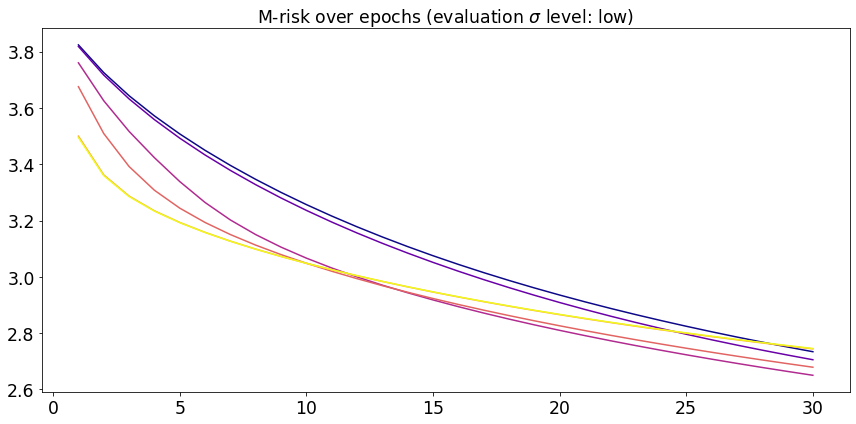

In [12]:
## Same as previous code block, but different aesthetics.

fig, ax = plt.subplots(1, 1, figsize=(12,6))

for task, colour in zip(toplot_tasks, task_colours):
    
    num_trials, num_epochs = dict_train[task].shape
    
    x_values = np.arange(0,num_epochs)+1
    losses_test = dict_test[task]
    mrisks_test = np.zeros_like(dict_train[task]) # initialize to zeros.
    for i, j in product(range(num_trials), range(num_epochs)):
        mrisks_test[i,j] = eval_custom(losses=losses_test[i,j,:], sigma=sigma_dict[type_of_eval])
    
    ## Mean over trials.
    y_train = np.mean(dict_train[task], axis=0)
    y_test = np.mean(mrisks_test, axis=0)
    y_test_err = np.std(mrisks_test, axis=0)
    ax.plot(x_values, y_test,
            color=colour,
            label="{} test".format(task),
            ls="-")
    #ax.fill_between(x=x_values,
    #                y1=y_test-y_test_err,
    #                y2=y_test+y_test_err,
    #                alpha=0.2, color=colour, lw=0)

ax.tick_params(labelsize=my_fontsize)
ax.set_title(r"M-risk over epochs (evaluation $\sigma$ level: {})".format(type_of_eval), size=my_fontsize)
plt.tight_layout()
#fname = os.path.join(img_dir,
#                     "{}_{}_{}_{}_{}.{}".format(type_of_eval, data, model, toplot_name, eval_type, my_ext))
#plt.savefig(fname=fname)
plt.show()


Doing: zero
Doing: low
Doing: med
Doing: high
Doing: inf


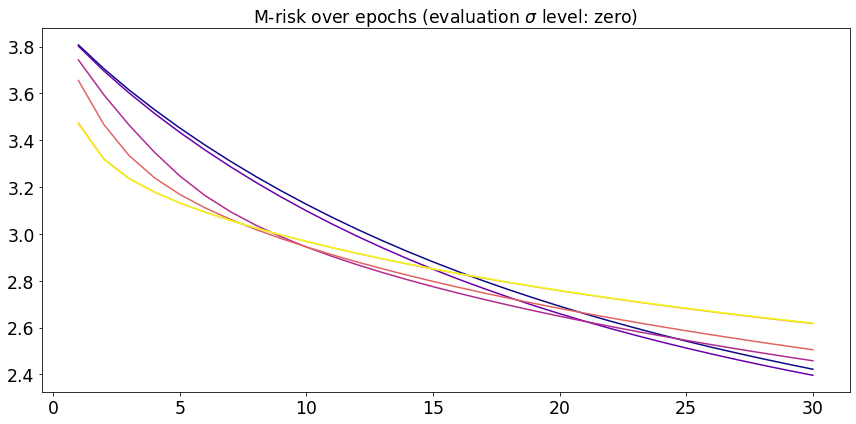

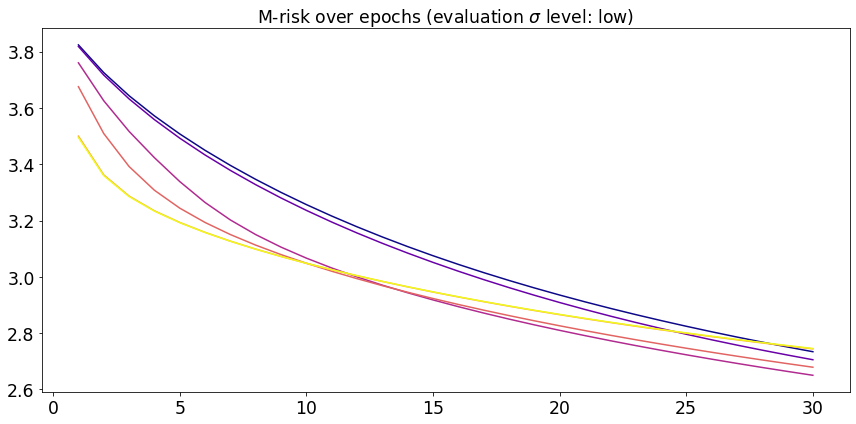

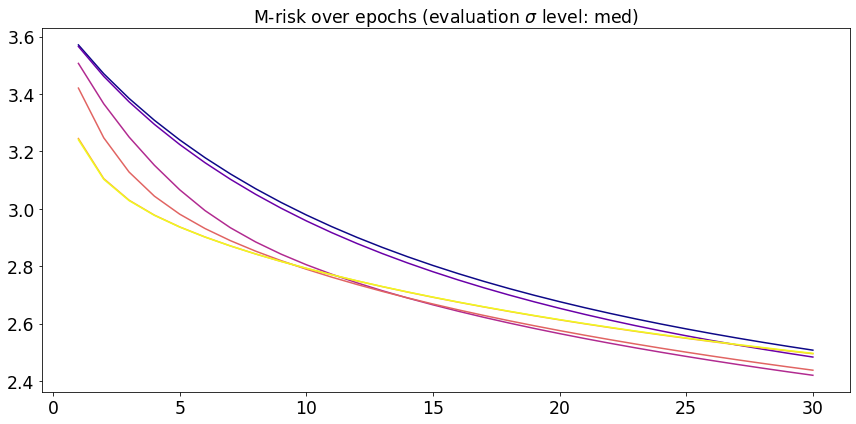

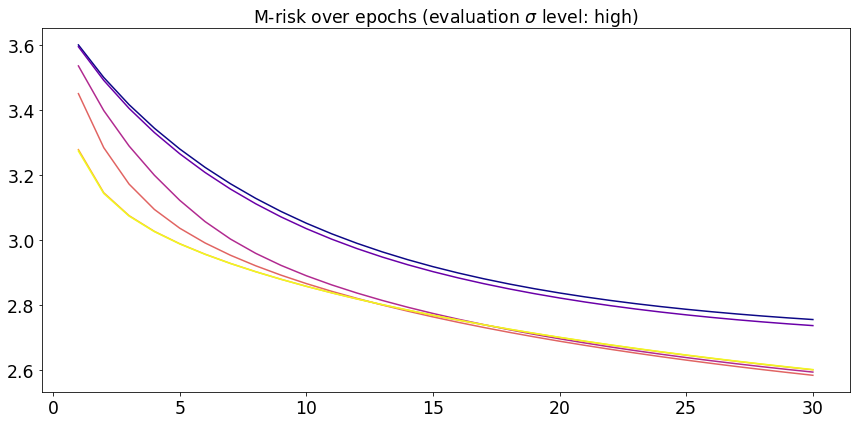

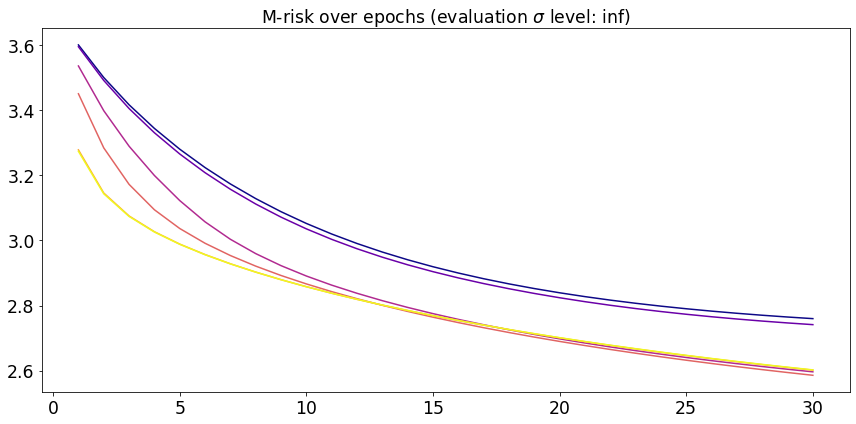

In [13]:
## Same as previous two blocks, but now looped just for printing.

for type_of_eval in ["zero", "low", "med", "high", "inf"]:
    
    print("Doing:", type_of_eval)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    for task, colour in zip(toplot_tasks, task_colours):

        num_trials, num_epochs = dict_train[task].shape

        x_values = np.arange(0,num_epochs)+1
        losses_test = dict_test[task]
        mrisks_test = np.zeros_like(dict_train[task]) # initialize to zeros.
        for i, j in product(range(num_trials), range(num_epochs)):
            mrisks_test[i,j] = eval_custom(losses=losses_test[i,j,:], sigma=sigma_dict[type_of_eval])

        ## Mean over trials.
        y_train = np.mean(dict_train[task], axis=0)
        y_test = np.mean(mrisks_test, axis=0)
        y_test_err = np.std(mrisks_test, axis=0)
        ax.plot(x_values, y_test,
                color=colour,
                label="{} test".format(task),
                ls="-")
        #ax.fill_between(x=x_values,
        #                y1=y_test-y_test_err,
        #                y2=y_test+y_test_err,
        #                alpha=0.2, color=colour, lw=0)

    ax.tick_params(labelsize=my_fontsize)
    ax.set_title(r"M-risk over epochs (evaluation $\sigma$ level: {})".format(type_of_eval), size=my_fontsize)
    plt.tight_layout()
    fname = os.path.join(img_dir,
                         "{}_{}_{}_{}_{}.{}".format(type_of_eval, data, model, toplot_name, eval_type, my_ext))
    plt.savefig(fname=fname)


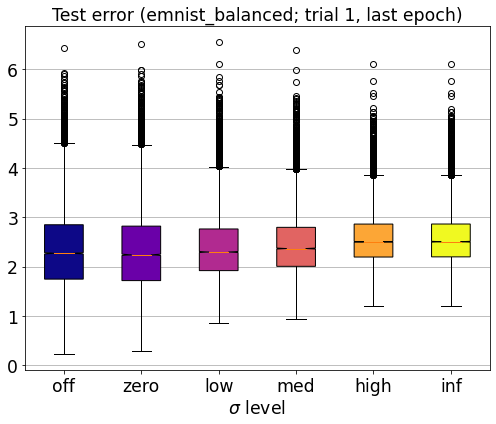

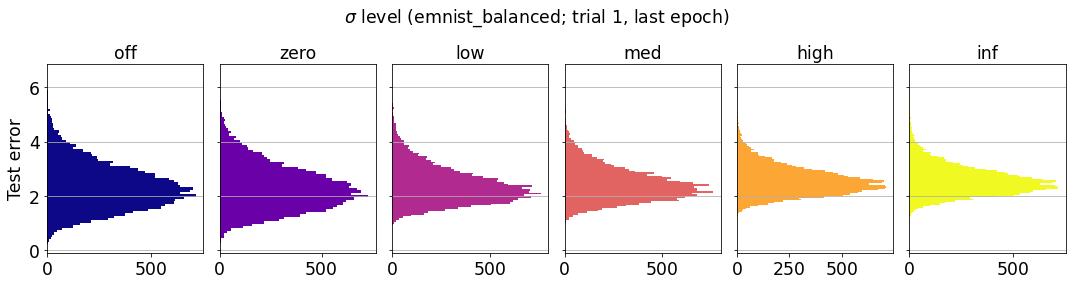

In [13]:
## Box-plots of test error, over sigma-dependent tasks.

todo_trial = 1
todo_epoch = -1

data_toplot = []
for task in toplot_tasks:
    data_toplot += [dict_test[task][todo_trial,todo_epoch,:]]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
bplot = ax.boxplot(data_toplot,
                   notch=True,
                   vert=True,
                   patch_artist=True,
                   labels=toplot_tasks)
ax.set_title(
    "Test error ({}; trial {}, last epoch)".format(data, todo_trial),
    size=my_fontsize
)
ax.yaxis.grid(True)
for patch, color in zip(bplot["boxes"], task_colours):
    patch.set_facecolor(color)
ax.tick_params(labelsize=my_fontsize)
ax.set_xlabel(r"$\sigma$ level", size=my_fontsize)
plt.tight_layout()
fname = os.path.join(img_dir,
                     "box_{}_{}_{}_{}.{}".format(data, model, toplot_name, eval_type, my_ext))
plt.savefig(fname=fname)
plt.show()


## Histograms of test error, over sigma-dependent tasks.

fig, axes = plt.subplots(nrows=1, ncols=len(toplot_tasks), figsize=(15,4), sharey=True)

for ax, task, colour in zip(axes,toplot_tasks,task_colours):
    ax.hist(dict_test[task][todo_trial,todo_epoch,:], bins="auto",
            color=colour, hatch=None, orientation="horizontal")
    ax.tick_params(labelsize=my_fontsize)
    ax.set_ylabel("Test error", size=my_fontsize)
    ax.set_title(task, size=my_fontsize)
    ax.yaxis.grid(True)
    ax.label_outer()
fig.suptitle(r"$\sigma$ level ({}; trial {}, last epoch)".format(data, todo_trial), size=my_fontsize)
fig.subplots_adjust(top=0.8)
plt.tight_layout()
fname = os.path.join(img_dir,
                     "hist_{}_{}_{}_{}.{}".format(data, model, toplot_name, eval_type, my_ext))
plt.savefig(fname=fname)
plt.show()


___